In [1]:
# EXPERIMENT NO. 1

# TITLE: VANILLA

# OBJECTIVE: Verify the working of DQN for Tokyo 2010

# PROCEDURE:  Train using Tokyo,2010 for 50 iterations - make 3 simultaneous copies
#             Shuffle days when training
#             Test using Tokyo, 2010 using greedy policy and best trained model
#             Test using Tokyo, 2011 using greedy policy and best trained model
#             Test using Wakkanai, 2011 using greedy policy and best trained model
#             Test using Minamidaito, 2011 using greedy policy and best trained model

#SETUP : 
#Battery      => 3.7V x 2500mAh = 9250 mWh, [MODEL: 785060 2500mAh]
#Solar Panel  => 500mW [55mm x 70mm, ECCN-3A991.o    HSCODE-8541402000] 
#Node         => 50mw to 500 mW, 10 duty cycles [DigiXBee3 PRO ZigBee 3.0]

# RESULTS:

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import random
import string
import pandas as pd
import numpy as np

In [4]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        file = './data/' + self.location +'/' + str(self.year) + '.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(file, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        #reshape solar_radiation into no_of_daysx24 array
        sradiation = solar_radiation.reshape(-1,24)
        #convert missing data in CSV files to zero
        sradiation[np.isnan(sradiation)] = 0
        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(sradiation) 
        self.sradiation = sradiation
        
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)

        self.senergy = self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60) 

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        if (tot_day_radiation < 3.5):
            day_state = 0
        elif (3.5 <= tot_day_radiation < 7):
            day_state = 1
        elif (7 <= tot_day_radiation < 12):
            day_state = 2
        elif (12 <= tot_day_radiation < 15):
            day_state = 3
        elif (15 <= tot_day_radiation < 17.5):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False

        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.day < self.NO_OF_DAYS -1):
                end_of_day = True
                self.hr = 0
                self.day += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                end_of_day = True
                end_of_year = True
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]



#Continuous Adaptive Power Manager using default ENO class
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 9250.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = 500   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.location = location
        self.year = year
        self.shuffle = shuffle
        self.trainmode = trainmode
        self.eno = ENO(self.location, self.year, shuffle)

        self.no_of_day_state = 6;

  
    
    
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.no_of_day_state-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state

    #reward function
    def rewardfn(self):
        R_PARAM = 20000 #chosen empirically for best results
        mu = 0
        sig = 0.05*R_PARAM #knee curve starts at approx. 2000mWhr of deviation
        
        if(np.abs(self.enp) <= 0.12*R_PARAM):
            norm_reward = (np.exp(-np.power((self.enp - mu)/sig, 2.)/2) / np.exp(-np.power((0 - mu)/sig, 2.)/2))
        else:
            norm_reward = -0.25 - 2.5*np.abs(self.enp/R_PARAM)
    
        return norm_reward
        
    
    def step(self, action):
        day_end = False
        year_end = False
        reward = 0
        
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        
        #code to record all the times battery levels have been exceeded
        self.enp = self.BOPT - self.batt
        
        #proceed to the next time step
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX

        if(day_end): #if eno object flags that the day has ended then give reward
            reward = self.rewardfn()
            
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
                if(self.batt == self.BMIN or self.batt == self.BMAX ):
                    self.batt = self.BOPT
                    reward = reward - 2 #penalty for violating battery limits
                
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        return [c_state, reward, day_end, year_end]



In [5]:
np.random.seed(230228)

In [6]:
#Class definitions for NN model and learning algorithm

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        
        self.out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [7]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
    
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] # return the argmax index

        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
# Hyper Parameters
LOCATION = 'tokyo'
YEAR = 2010

BATCH_SIZE = 24
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.9                # parameter decay
TARGET_REPLACE_ITER = 24*7*4*2    # target update frequency (every two months)
MEMORY_CAPACITY = 24*7*4*6      # store upto six month worth of memory   

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,4)
N_STATES = 4 #number of state space parameter [batt, enp, henergy, fcast]
HIDDEN_LAYER = 20

In [9]:
# #Check reward function

# test = CAPM(LOCATION,YEAR,shuffle=False) #refer to eno_class.py class file
# y1 = np.empty(1)
# for x in np.arange(-test.BMAX/2,test.BMAX/2):
#     test.enp = x
#     y1 = np.append(y1,test.rewardfn())
# y1 = np.delete(y1, 0, 0) #remove the first row which is garbage

# enp = np.arange(-test.BMAX/2,test.BMAX/2)
# fig, ax = plt.subplots()
# ax.plot(enp, y1)

# ax.set(xlabel='ENP', ylabel='Reward',
#        title='Reward Function')
# ax.grid()
# plt.show()




End of Year
Average reward = -0.30732250613931533

End of Year
Average reward = 0.2494885422883597

End of Year
Average reward = 0.38299518171316643

End of Year
Average reward = 0.29177114442357915

End of Year
Average reward = 0.3179523561935464

End of Year
Average reward = 0.26041715975307855

End of Year
Average reward = 0.26888340636743274

End of Year
Average reward = 0.15054261287198797

End of Year
Average reward = 0.1978215281324214

End of Year
Average reward = 0.30638173193318863

End of Year
Average reward = 0.43427204821605825

End of Year
Average reward = 0.24350071097067036

End of Year
Average reward = 0.4345969893918829

End of Year
Average reward = 0.3085909844873702

End of Year
Average reward = 0.3466362415960306

End of Year
Average reward = 0.39207433680293413

End of Year
Average reward = 0.32643602873218286

End of Year
Average reward = 0.26719198580550274

End of Year
Average reward = 0.1488103909294355

End of Year
Average reward = 0.16139044444170825

End o

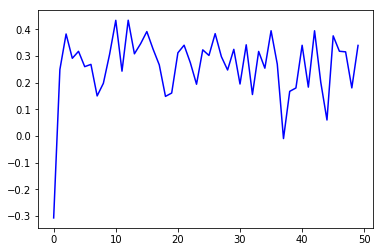

In [10]:
#TRAIN USING TOKYO 2010 data
dqn = DQN() #refer to learner_class.py class file
capm = CAPM(LOCATION,YEAR,shuffle=True, trainmode=True) #refer to eno_class.py class file

NO_OF_ITERATIONS = 50
best_avg_reward = -1000 #initialize best average reward to very low value
PFILENAME = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8)) #create random filename
PFILENAME = PFILENAME + ".pt" #this file stores the best model

avg_reward_rec = np.empty(1)

for iteration in range(NO_OF_ITERATIONS):

    print('\nCollecting experience... Iteration:', iteration)
#     print("EPSILON = ", EPSILON)
#     print("LR = ", LR)
#     print("LAMBDA = ", LAMBDA)

    s, r, day_end, year_end = capm.reset()
    record = np.empty(4)

    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(s)
        #state = [batt, enp, henergy, fcast]
        record = np.vstack((record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

        # take action
        s_, r, day_end, year_end = capm.step(a)

        temp_transitions = np.hstack((s, [a, r], s_))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] = r #broadcast reward to all states
            decay_factor = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5] = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if (year_end):
            print("End of Year")
            break

        s = s_

    record = np.delete(record, 0, 0) #remove the first row which is garbage

    reward_rec = record[:,2]
    reward_rec = reward_rec[reward_rec != 0]
    print("Average reward =", np.mean(reward_rec) )
    avg_reward_rec = np.append(avg_reward_rec, np.mean(reward_rec))

    if (iteration > 20): #save the best models only after 20 iterations
        if(best_avg_reward < np.mean(reward_rec)):
            best_avg_reward = np.mean(reward_rec)
            print("Better reward -> ", best_avg_reward)
            print("Saving model")
            torch.save(dqn.eval_net.state_dict(), PFILENAME)

avg_reward_rec = np.delete(avg_reward_rec, 0, 0) #remove the first row which is garbage
plt.plot(avg_reward_rec,'b')

In [11]:
# #Plot the reward and battery for the entire year run on a day by day basis

# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle("TOKYO, 2010  DAY %s" %(DAY))

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("Harvested Energy")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1.2])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.set_title("YEAR RUN")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(12, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    
#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()


Year run test
Model Used:  EV97D28B.pt
End of Year
Average Reward =  0.6153152787446404


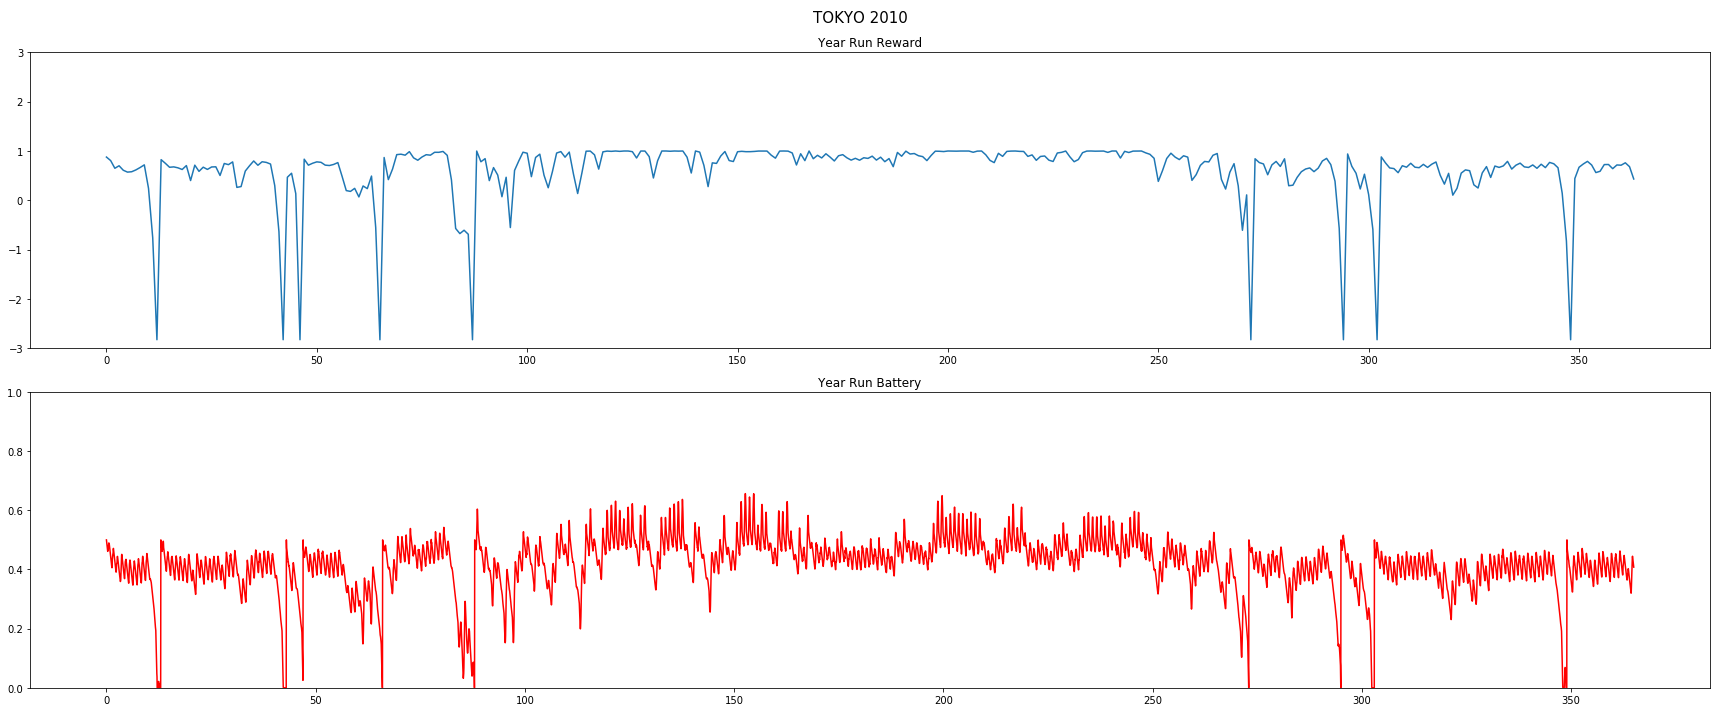

In [12]:
#Test the trained model for TOKYO 2010
# dqn = DQN()
capm = CAPM('tokyo',2010, shuffle=False, trainmode=True)
print('\nYear run test')
print('Model Used: ',PFILENAME)

#load the best model
dqn.eval_net.load_state_dict(torch.load(PFILENAME))
dqn.eval_net.eval()
s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    a = dqn.choose_greedy_action(s)

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        print("End of Year")
        break
       
    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage



#Plot the reward and battery for the entire year run
NO_OF_DAYS = capm.eno.NO_OF_DAYS
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
print('Average Reward = ', np.mean(yr_test_reward_rec))


fig = plt.figure(figsize=(24,10))
fig.suptitle('TOKYO 2010', fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(yr_test_reward_rec)
ax1.set_title("\n\nYear Run Reward")
ax1.set_ylim([-3,3])

ax2 = fig.add_subplot(212)
ax2.plot(yr_test_record[:,0],'r')
ax2.set_title("Year Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

fig.tight_layout()
plt.show()


Year run test
Model Used:  EV97D28B.pt
End of Year
Average Reward =  0.6764594664704914


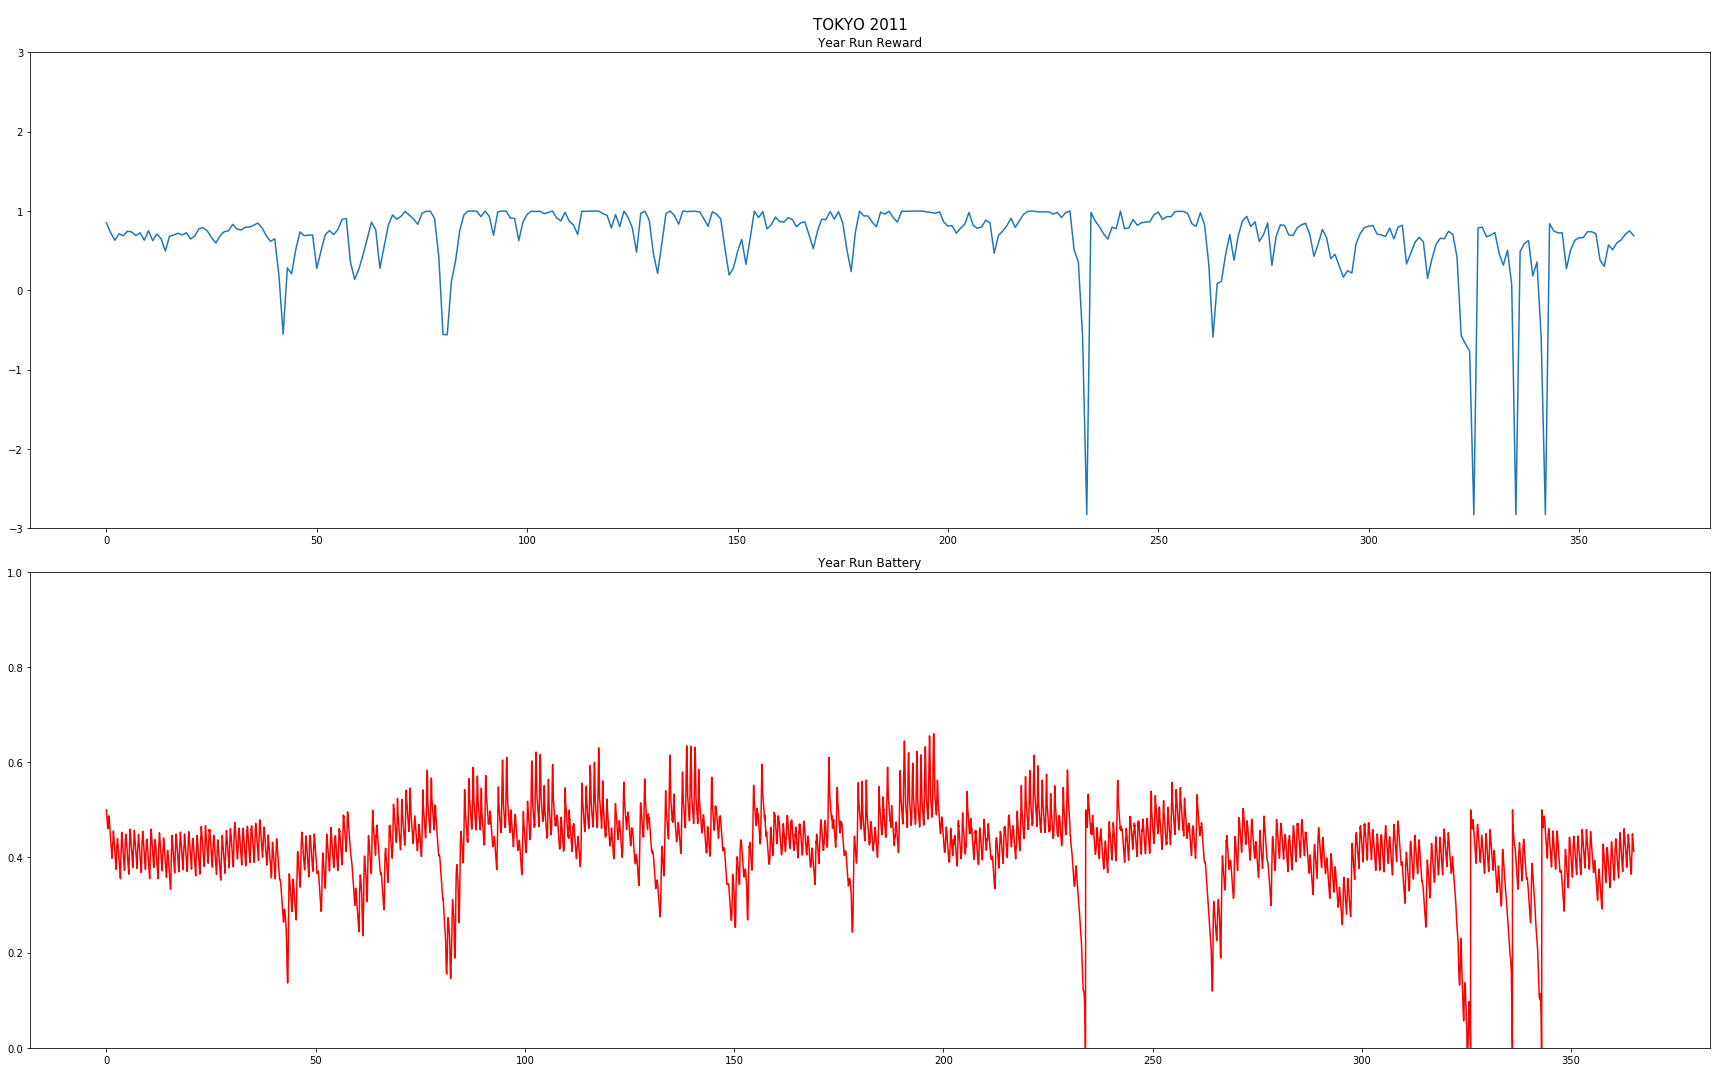

In [13]:
#Test the trained model for TOKYO 2011
# dqn = DQN()
capm = CAPM('tokyo',2011, shuffle=False, trainmode=True)
print('\nYear run test')
print('Model Used: ',PFILENAME)

#load the best model
dqn.eval_net.load_state_dict(torch.load(PFILENAME))
dqn.eval_net.eval()
s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    a = dqn.choose_greedy_action(s)

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        print("End of Year")
        break
       
    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage



#Plot the reward and battery for the entire year run
NO_OF_DAYS = capm.eno.NO_OF_DAYS
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
print('Average Reward = ', np.mean(yr_test_reward_rec))


fig = plt.figure(figsize=(24,15))
fig.suptitle('TOKYO 2011', fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(yr_test_reward_rec)
ax1.set_title("\n\nYear Run Reward")
ax1.set_ylim([-3,3])

ax2 = fig.add_subplot(212)
ax2.plot(yr_test_record[:,0],'r')
ax2.set_title("Year Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

fig.tight_layout()
plt.show()

In [14]:
# #Plot the reward and battery for the entire year run on a day by day basis

# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle("TOKYO, 2011  DAY %s" %(DAY))

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("Harvested Energy")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1.2])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.set_title("YEAR RUN")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(12, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    
#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()


Year run test
Model Used:  EV97D28B.pt
End of Year
Average Reward =  0.3918778165794403


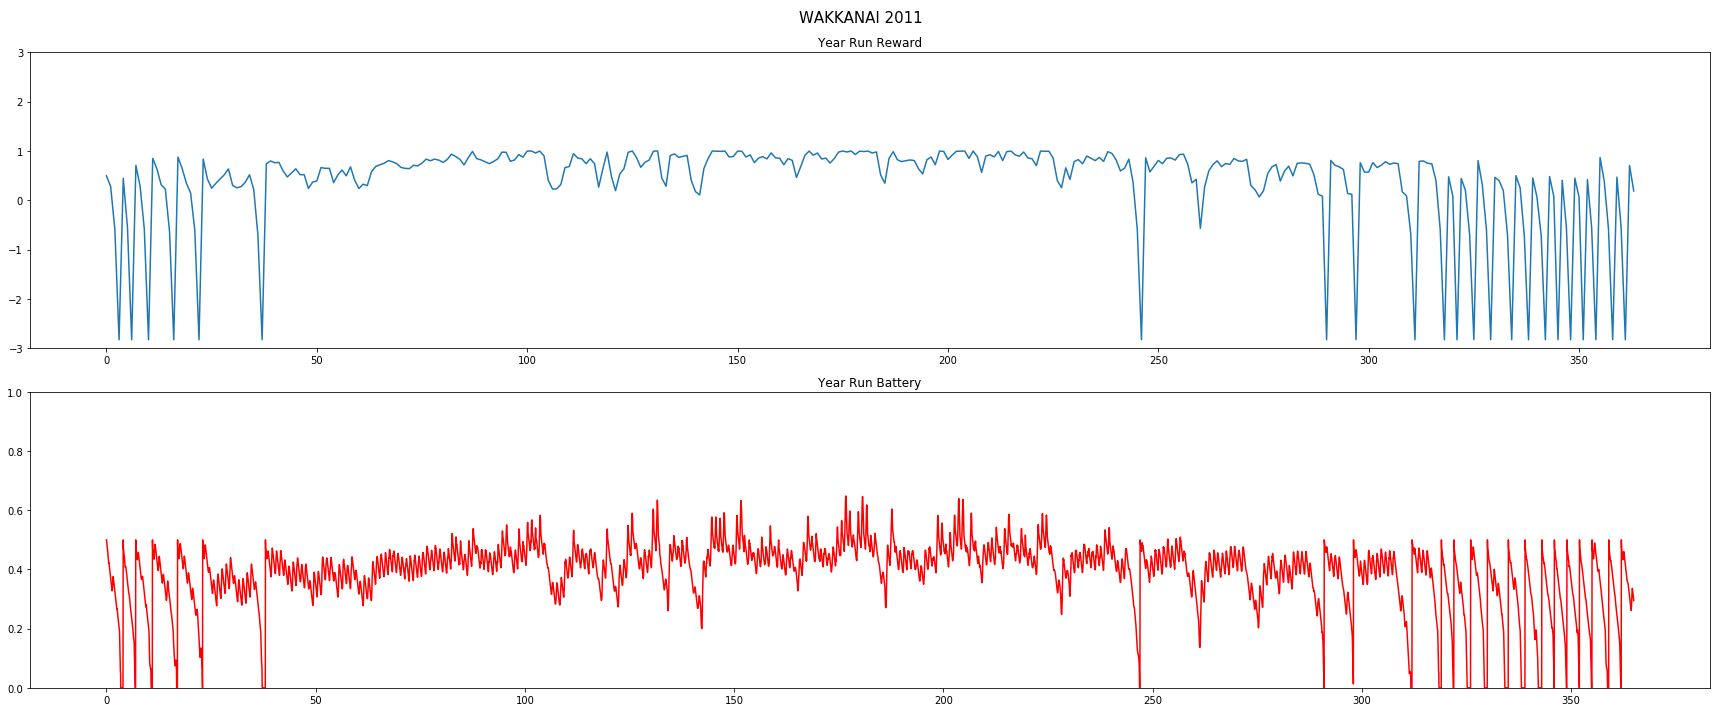

In [15]:
#Test the trained model for WAKKANAI, 2011
# dqn = DQN()
capm = CAPM('wakkanai',2011, shuffle=False, trainmode=True)
print('\nYear run test')
print('Model Used: ',PFILENAME)

#load the best model
dqn.eval_net.load_state_dict(torch.load(PFILENAME))
dqn.eval_net.eval()
s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    a = dqn.choose_greedy_action(s)

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        print("End of Year")
        break
       
    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage



#Plot the reward and battery for the entire year run
NO_OF_DAYS = capm.eno.NO_OF_DAYS
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
print('Average Reward = ', np.mean(yr_test_reward_rec))


fig = plt.figure(figsize=(24,10))
fig.suptitle('WAKKANAI 2011', fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(yr_test_reward_rec)
ax1.set_title("\n\nYear Run Reward")
ax1.set_ylim([-3,3])

ax2 = fig.add_subplot(212)
ax2.plot(yr_test_record[:,0],'r')
ax2.set_title("Year Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

fig.tight_layout()
plt.show()

In [16]:
# #Plot the reward and battery for the entire year run on a day by day basis

# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle("WAKKANAI, 2011  DAY %s" %(DAY))

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("Harvested Energy")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1.2])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.set_title("YEAR RUN")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(12, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    
#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()


Year run test
Model Used:  EV97D28B.pt
End of Year
Average Reward =  0.7733830102553478


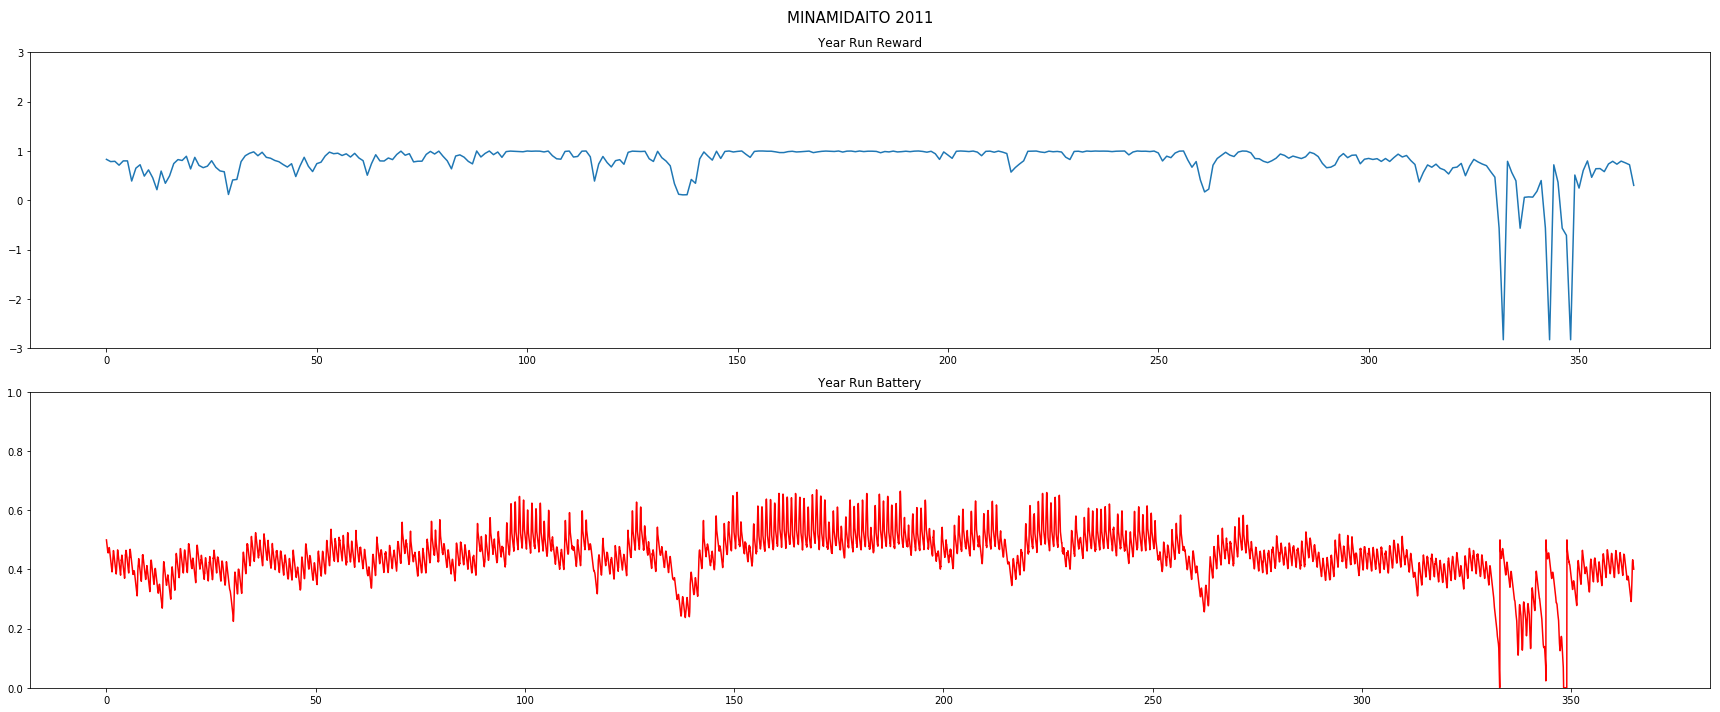

In [17]:
#Test the trained model for MINAMIDAITO, 2011
# dqn = DQN()
capm = CAPM('minamidaito',2011, shuffle=False, trainmode=True)
print('\nYear run test')
print('Model Used: ',PFILENAME)

#load the best model
dqn.eval_net.load_state_dict(torch.load(PFILENAME))
dqn.eval_net.eval()
s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    a = dqn.choose_greedy_action(s)

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        print("End of Year")
        break
       
    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage



#Plot the reward and battery for the entire year run
NO_OF_DAYS = capm.eno.NO_OF_DAYS
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
print('Average Reward = ', np.mean(yr_test_reward_rec))


fig = plt.figure(figsize=(24,10))
fig.suptitle('MINAMIDAITO 2011', fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(yr_test_reward_rec)
ax1.set_title("\n\nYear Run Reward")
ax1.set_ylim([-3,3])

ax2 = fig.add_subplot(212)
ax2.plot(yr_test_record[:,0],'r')
ax2.set_title("Year Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

fig.tight_layout()
plt.show()

In [18]:
# # Plot the reward and battery for the entire year run on a day by day basis

# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(155,170):#range(capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle("MINAMIDAITO, 2011  DAY %s" %(DAY))

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("Harvested Energy")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1.2])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.set_title("YEAR RUN")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(12, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    
#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()